In [1]:
import warnings
warnings.filterwarnings('always')

import pandas as pd
import urllib.request
import numpy as np
from IPython.display import display
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from textwrap import wrap
from sklearn.svm import LinearSVC
from sklearn.svm import SVC




/Users/tonyd/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/tonyd/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/tonyd/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/tonyd/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/tonyd/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/tonyd/an

/Users/tonyd/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/tonyd/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/tonyd/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/tonyd/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/tonyd/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/tonyd/an

In [16]:
#TCGA dictionary information
tcga_dict = open("tcga_dictionaries.txt","r")
dict_name_index = 0 #Set dictionary index counter to 0
for line in tcga_dict:
    if line.startswith("#"): #If line starts with #, the next line will be a known dictionary
        dict_name_index += 1
    elif dict_name_index == 5:
        code_to_disease = eval(line)
        

In [17]:
def getDataAndLabels(cases):
    labels_string = cases.cancer_type
    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(labels_string)

    # Get rid of the cancer type and patient_id columns 
    data = cases[cases.columns[3:]]
    return {'data': data, 'labels': labels , 'label_encoder': le }




In [5]:
print('Loading case data ...')

#cases_800                    = pd.read_csv("pancancer_case_features_800.csv")
#cases_1000                   = pd.read_csv("pancancer_case_features_1000.csv")
#cases_1500                   = pd.read_csv("pancancer_case_features_1500.csv")
#cases_bestfit_8000           = pd.read_csv("pancancer_case_features_bestfit_8000_topgenes_1000.csv")
cases_bestfit_10000          = pd.read_csv("pancancer_case_features_bestfit_10000_topgenes_2000.csv")
cases_bestfit_15000          = pd.read_csv("pancancer_case_features_bestfit_15000_topgenes_3000.csv")
cases_bestfit_15000_allgenes = pd.read_csv("pancancer_case_features_bestfit_15000_topgenes_None.csv")
cases_allgenes               = pd.read_csv("pancancer_case_features_all.csv")
all_data = {
    #'800':                     getDataAndLabels(cases_800),
    #'1000':                    getDataAndLabels(cases_1000),
    #'1500':                    getDataAndLabels(cases_1500),
    'best_fit_10000':          getDataAndLabels(cases_bestfit_10000),
    'best_fit_15000':          getDataAndLabels(cases_bestfit_15000),
    'best_fit_15000_allgenes': getDataAndLabels(cases_bestfit_15000_allgenes),
    'genes_all':               getDataAndLabels(cases_allgenes)
}
print("done.")

Loading case data ...
done.


In [ ]:
def foldData(data, labels):
    skf = StratifiedKFold(n_splits=10)
    folds = []
    for train_index, dev_index in skf.split(data, labels):
        train_data, dev_data     = data.values[train_index], data.values[dev_index]
        train_labels, dev_labels = labels[train_index], labels[dev_index]        
        folds.append( {'train_data': train_data, 'train_labels': train_labels, 
                        'dev_data':   dev_data,   'dev_labels': dev_labels })
    return folds



In [18]:
def splitData(data, labels):
    train_data_all, test_data, train_labels_all, test_labels = train_test_split(data, labels,
                                                               stratify=labels, 
                                                               test_size=0.25)

    train_data, dev_data, train_labels, dev_labels = train_test_split(train_data_all, train_labels_all,
                                                                     stratify=train_labels_all, 
                                                                     test_size=0.20)

    print("training data:", train_data.shape)
    print("dev data     :", dev_data.shape)
    print("test data    :",  test_data.shape)
    return {'train_data': train_data, 'train_labels': train_labels, 
            'dev_data':   dev_data,   'dev_labels': dev_labels,
            'test_data':  test_data,  'test_labels': test_labels}



In [19]:
def getBestParams(train_data, train_labels):
    #mini_train_data, mini_test_data, mini_train_labels, mini_test_labels = train_test_split(train_data, train_labels,
    #                                    stratify=train_labels, 
    #                                    test_size=0.55)
    
    #
    # Logistic Regression
    #
    lr = LogisticRegression(penalty='l2', multi_class = 'ovr', solver='liblinear', max_iter=150)
    params = {'C': [0.1, 0.25,  0.5,]}
    logit = GridSearchCV(lr, params, cv=5,
                         scoring='accuracy', return_train_score=True)

    # Fit  training data
    logit.fit(train_data, train_labels)  
    # Show the best C parameter to use and the expected accuracy
    print('\nLogistic Regression Classifier, L2 regularization')
    print(' Best param:', logit.best_params_)
    print(' Accuracy:  ', np.round(logit.best_score_, 4) )
    
    return logit.best_params_

In [20]:
def getBestParamsSVM(train_data, train_labels):
    #mini_train_data, mini_test_data, mini_train_labels, mini_test_labels = train_test_split(train_data, train_labels,
    #                                    stratify=train_labels, 
    #                                    test_size=0.55)
    
    #
    # SVM
    #
    classifier = LinearSVC(penalty='l2')

    params = {'C': [0.01, 0.1, 0.5]}
    svm = GridSearchCV(classifier, params, cv=4, 
                       scoring='accuracy', return_train_score=True)

    # Fit  training data
    svm.fit(train_data, train_labels)  
    # Show the best C parameter to use and the expected accuracy
    print('\nSVM Classifier')
    print(' Best param:', svm.best_params_)
    print(' Accuracy:  ', np.round(svm.best_score_, 4) )
    
    return svm.best_params_

In [ ]:
#
#  Find best C param for Logistic Regression L2
#
data   = all_data['best_fit_1000']['data']
labels = all_data['best_fit_1000']['labels']
splits = splitData(data, labels)
logit_best_params = getBestParams(splits['train_data'], splits['train_labels'])

#
#  Find best C param for Linear SVM
#
svm_best_params = getBestParamsSVM(splits['train_data'], splits['train_labels'])


print("\n\n")


#
#  Find best C param for Logistic Regression L2
#
data   = all_data['best_fit_8000']['data']
labels = all_data['best_fit_8000']['labels']
splits = splitData(data, labels)
logit_best_params = getBestParams(splits['train_data'], splits['train_labels'])

#
#  Find best C param for Linear SVM
#
svm_best_params = getBestParamsSVM(splits['train_data'], splits['train_labels'])

In [21]:
def coords_of_max(theArray, n):
    # Flatten the 2D array
    flat = theArray.flatten()
    # Partition so that the we know the sort order for
    # the cells with the highest values.  We just
    # care about the top n highest values.  So for example,
    # if n = 3, get return 3 indices.  
    indices = np.argpartition(flat, -n)[-n:]
    # Reverse so that we show index of highest value first
    # (descending)
    indices = indices[np.argsort(-flat[indices])]
    # Now return the coordinates for these indices
    # for a 2D array.  This will return 2 arrays,
    # the first for the row index, the second for the
    # column index.  The row index represents the
    # actual digit, the column index represents
    # the confused digit
    return np.unravel_index(indices, theArray.shape)

In [22]:
def plotMetrics(precision_l1, recall_l1, 
                accuracy, precision, recall, 
                precision_by_label, recall_by_label, 
                svm_accuracy, svm_precision, svm_recall, 
                svm_precision_by_label, svm_recall_by_label, 
                confusion, feature_size, label_encoder):
    labels = [ '\n'.join(wrap(l, 8)) for l in feature_size ]       
    
    plt.rcParams["figure.figsize"] = (20,6)

    plt.plot(labels, precision, color='olivedrab', 
             linewidth=3, label='Precision (Logistic regression) ', marker='o' )
    plt.plot(labels, recall, color='olivedrab', linestyle='dashed',
             linewidth=3, label='Recall (Logistic regression)', marker='o' )
    #plt.plot(labels, accuracy, color='darkolivegreen', linestyle=':',
    #         linewidth=3, label='Accuracy (Logistic regression)', marker='v' )

    plt.plot(labels, svm_precision, color='slateblue', 
             linewidth=3, label='Precision (SVM)', marker='o' )
    plt.plot(labels, svm_recall, color='slateblue', linestyle='dashed',
             linewidth=3, label='Recall (SVM)', marker='o' )
    #plt.plot(labels, svm_accuracy, color='darkslateblue', linestyle=':',
    #         linewidth=3, label='Accuracy (SVM)', marker='v' )

    #plt.plot(labels, precision_l1, color='gray',alpha=.4,
    #         linewidth=3, label='L1 precision at different C values', marker='o' )
    #plt.plot(labels, recall_l1, color='gray', linestyle='dashed',alpha=.6,
    #         linewidth=3, label='L1 at different C values', marker='o' )
    
    
    plt.yticks(np.arange(.42, .65, .01))
    plt.ylabel('Precision, Recall', fontsize=20)
    plt.xlabel('Feature size with L1 regularization at different C parameters', fontsize=20, labelpad=20)
    plt.legend()
    plt.grid()
    plt.show()
    
    # find optimal f1
    best_idx = np.argmax(precision)
    
    # Show precision and recall across different labels
    showPrecisionRecallPairByLabel(precision_by_label[best_idx], recall_by_label[best_idx], label_encoder,
                                  'Logistic Regression', ['olivedrab', 'darkolivegreen'])
    showPrecisionRecallPairByLabel(svm_precision_by_label[best_idx], svm_recall_by_label[best_idx], label_encoder,
                                  'SVM', ['slateblue', 'darkslateblue'])
    
    
    # Get the confusion matrix for the optimal precision
    # Show the labels that have the highest error rate
    conf_mx = confusion[best_idx]
    showTopConfused(conf_mx, label_encoder)
    


In [23]:
def showTopConfused(conf_mx, label_encoder):
    # Determine the error rates for each misclassification pair
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    # Set the error rates for correctly classified pairs (the diagonal) to zero
    np.fill_diagonal(norm_conf_mx, 0)
    
    max_coords = coords_of_max(norm_conf_mx, 20)
    confusion_rows = []
    for i in range(len(max_coords[0])):

        # This is the actual label
        actual_label_idx  = max_coords[0][i]
        actual_label      = label_encoder.inverse_transform([actual_label_idx])[0]

        # This is the predicted label
        predicted_label_idx = max_coords[1][i]
        predicted_label = label_encoder.inverse_transform([predicted_label_idx])[0]
        
        # This is the error rate
        error_rate  = norm_conf_mx[max_coords[0][i], max_coords[1][i]]
        error_count = conf_mx[max_coords[0][i], max_coords[1][i]]

        row = list([ actual_label,                     
                     predicted_label,
                     code_to_disease[actual_label][0], 
                     code_to_disease[predicted_label][0], 
                     error_rate, 
                     error_count ])
        confusion_rows.append(row)
    
    df = pd.DataFrame(confusion_rows, columns=['actual', 'predicted',  'actual_name', 'predicted_name', 'error_rate', 'error_count'])
    display(df)

        

In [24]:
def showPrecisionRecallPairByLabel(precision_by_label, recall_by_label, label_encoder, classifier_name, colors):
    labels = []
    for i in range(len(precision_by_label)):
        label = label_encoder.inverse_transform([i])[0]
        labels.append(label)
    
    y_pos = np.arange(len(labels))    

    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)

    ax1.invert_xaxis()
    ax1.yaxis.tick_right()
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels)
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
        
    ax1.barh(y_pos, precision_by_label, color=colors[0] , label="precision")
    ax2.barh(y_pos, recall_by_label,    color=colors[1],  label='recall')

    ax1.set_title('Precision( ' + classifier_name + ')')
    ax2.set_title('Recall (' + classifier_name + ')')
    
    plt.grid()
    plt.show()
    

In [25]:
def runLogitL1(train_data, train_labels, dev_data, dev_labels, c_param):
    l1 = LogisticRegression(penalty='l1', tol=.01, 
                            solver="liblinear", multi_class="ovr",
                            max_iter=500, C=c_param)
    # Fit model
    l1.fit(train_data, train_labels) 
    # Predict
    predict = l1.predict(dev_data)
    # Get precision, recall, f1 scores
    scores = precision_recall_fscore_support(dev_labels, predict, average='weighted')  
    
    # Get the features with non-zero coefficients.  We will use
    # this list to reduce the features for the
    # following logistic regression with L2 regularization
    non_zero_sums = np.where(np.sum(l1.coef_, axis=0) != 0)
    names = np.array(list(train_data.columns))
    non_zero_names = names[non_zero_sums] 
    
    return {'scores': scores, 'non_zero_genes': non_zero_names}

In [26]:
def eliminateFeatures(train_data, train_labels, dev_data, dev_labels, 
                      logit_C_param, svm_C_param, label_encoder):

    params = {'C':  [1000, 100, 10, 1, .5, .3, .1, .05]}


    # Now perform logistic regression on this training set with reduced features
    # as well as the orginal non-reduced training set.  Run over different
    # C values to plot differences in accuracy
    precision_l1        = []
    recall_l1           = []
    
    accuracy            = []
    precision           = []
    recall              = []
    precision_by_label  = []
    recall_by_label     = []
    
    svm_accuracy            = []
    svm_precision           = []
    svm_recall              = []
    svm_precision_by_label  = []
    svm_recall_by_label     = []

    feature_size        = []
    confusion           = []


    for c_param in reversed(params['C']):
        # Keep this random seed here to make comparison easier.
        np.random.seed(0)

        #
        # Perform Logistic Regression on different C values
        # using L1 regularization
        #
        l1_info = runLogitL1(train_data, train_labels, dev_data, dev_labels, c_param)    
        non_zero_genes = l1_info['non_zero_genes']
        feature_size.append(str(len(non_zero_genes)) + ' (L1 C=' + str(c_param) + ")")
        precision_l1.append(l1_info['scores'][0])
        recall_l1.append(l1_info['scores'][1])


        #
        # Reduce feature size, only keeping features with non-zero weights 
        # found using l1 regularization
        #
        min_train_data = train_data[non_zero_genes]
        min_dev_data   = dev_data[non_zero_genes]


        # Run logistic regression with L2 regularization on reduced
        # feature set
        lr = LogisticRegression(penalty='l2', tol=.01, max_iter=150, 
                                C=logit_C_param, solver="liblinear", multi_class="ovr")
        lr.fit(min_train_data, train_labels) 
        predict = lr.predict(min_dev_data)

        # Get precision, recall, f1 scores
        the_accuracy = accuracy_score(dev_labels, predict)
        scores = precision_recall_fscore_support(dev_labels, predict, average='weighted')
        scores_by_label = precision_recall_fscore_support(dev_labels, predict, average=None)

        # Get confusion matrix
        confusion_mx = confusion_matrix(dev_labels, predict)

        accuracy.append(the_accuracy)
        precision.append(scores[0])
        recall.append(scores[1])
        precision_by_label.append(scores_by_label[0])
        recall_by_label.append(scores_by_label[1])
        confusion.append(confusion_mx)
        
        #
        # Run Linear SVM
        #
        svm = LinearSVC(penalty='l2', C=svm_C_param)

        svm.fit(min_train_data, train_labels,) 
        predict = svm.predict(min_dev_data)

        # Get precision, recall, f1 scores
        svm_accuracy_score = accuracy_score(dev_labels, predict)
        svm_scores = precision_recall_fscore_support(dev_labels, predict, average='weighted')
        svm_scores_by_label = precision_recall_fscore_support(dev_labels, predict, average=None)

        svm_accuracy.append(svm_accuracy_score)
        svm_precision.append(svm_scores[0])
        svm_recall.append(svm_scores[1])
        svm_precision_by_label.append(svm_scores_by_label[0])
        svm_recall_by_label.append(svm_scores_by_label[1])
    
    # print best precision and recall 
    best_idx = np.argmax(precision)
    print("\nBest precision", feature_size[best_idx])
    print("  precision:", np.round(precision[best_idx], 4))  
    print("  recall:   ", np.round(recall[best_idx], 4))  

    best_idx = np.argmax(recall)
    print("\nBest recall", feature_size[best_idx])
    print("  precision:", np.round(precision[best_idx], 4))  
    print("  recall:   ", np.round(recall[best_idx], 4))  
    

    plotMetrics(precision_l1, recall_l1, 
                accuracy, precision, recall, 
                precision_by_label, recall_by_label,
                svm_accuracy, svm_precision, svm_recall, 
                svm_precision_by_label, svm_recall_by_label,
                confusion, feature_size, label_encoder)


In [27]:
#
#  Run classifier on each binary matrix, that has different
#  number of columns (genes).  Iterate through different
#  C values, using Logistic Regression L1 regularization 
#  to eliminate features.  Now run Logistic Regression, L2
#  regularization and keep track of precision, recall,
#  and confusion matrix.  Plot these metrics per feature
#  size and show the confusion matrix for the best performing
#  feature size.
#
def runClassifier(name, logit_c_param=.1, svm_c_param=.01):
    warnings.filterwarnings('ignore')
    data_object    = all_data[name]
    data          = data_object['data']
    labels        = data_object['labels']
    label_encoder = data_object['label_encoder']
    splits = splitData(data, labels)
    eliminateFeatures(splits['train_data'], splits['train_labels'],
                      splits['dev_data'], splits['dev_labels'], 
                      logit_c_param, svm_c_param, label_encoder)

training data: (6004, 10000)
dev data     : (1502, 10000)
test data    : (2502, 10000)

Best precision 9938 (L1 C=100)
  precision: 0.5931
  recall:    0.5619

Best recall 9938 (L1 C=100)
  precision: 0.5931
  recall:    0.5619


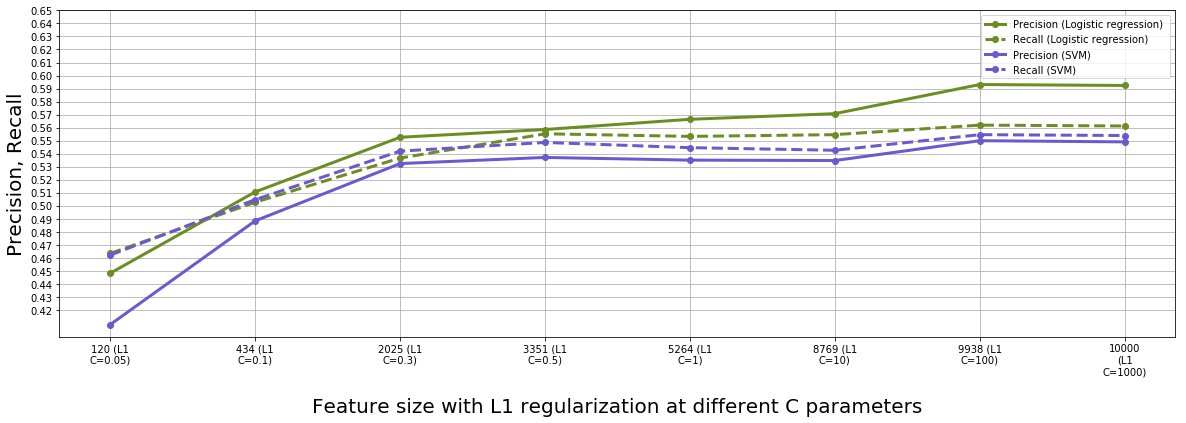

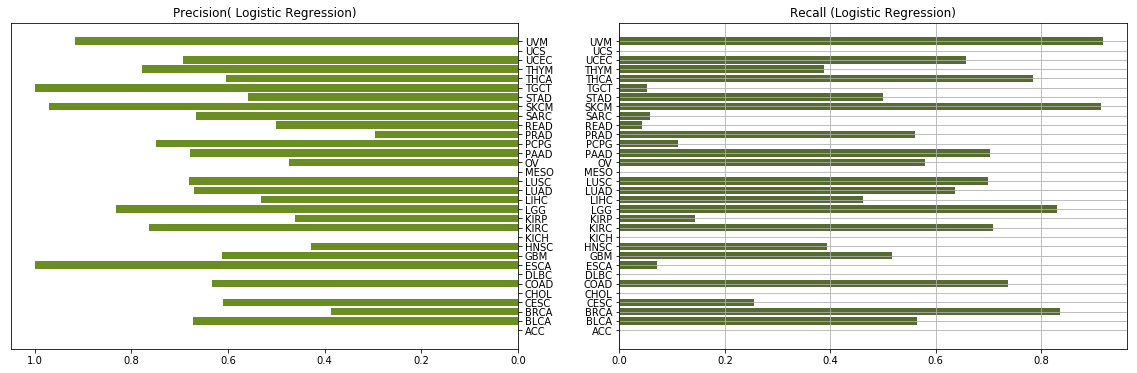

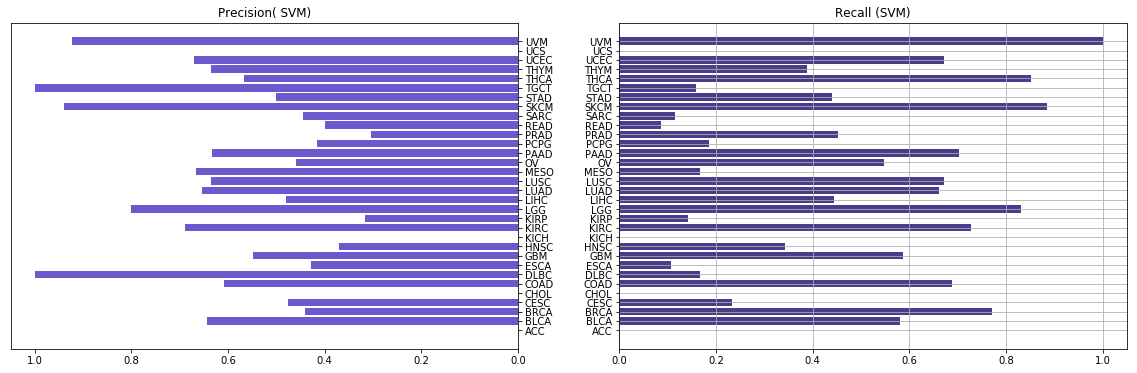

,actual,predicted,actual_name,predicted_name,error_rate,error_count
0,READ,COAD,Rectum_adenocarcinoma,Colon_adenocarcinoma,0.652174,15
1,UCS,BRCA,Uterine_Carcinosarcoma,Breast_invasive_carcinoma,0.555556,5
2,MESO,PRAD,Mesothelioma,Prostate_adenocarcinoma,0.500000,6
3,PCPG,PRAD,Pheochromocytoma_and_Paraganglioma,Prostate_adenocarcinoma,0.407407,11
4,KICH,PRAD,Kidney_Chromophobe,Prostate_adenocarcinoma,0.400000,4
5,THYM,PRAD,Thymoma,Prostate_adenocarcinoma,0.388889,7
6,SARC,BRCA,Sarcoma,Breast_invasive_carcinoma,0.371429,13
7,TGCT,PRAD,Testicular_Germ_Cell_Tumors,Prostate_adenocarcinoma,0.368421,7
8,ACC,BRCA,Adrenocortical_carcinoma,Breast_invasive_carcinoma,0.357143,5
9,KIRP,BRCA,Kidney_renal_papillary_cell_carcinoma,Breast_invasive_carcinoma,0.357143,15


In [28]:
runClassifier('best_fit_10000', logit_c_param=.1, svm_c_param=.01)


training data: (6004, 10000)
dev data     : (1502, 10000)
test data    : (2502, 10000)

Best precision 10000 (L1 C=1000)
  precision: 0.5556
  recall:    0.5253

Best recall 9921 (L1 C=100)
  precision: 0.5556
  recall:    0.526


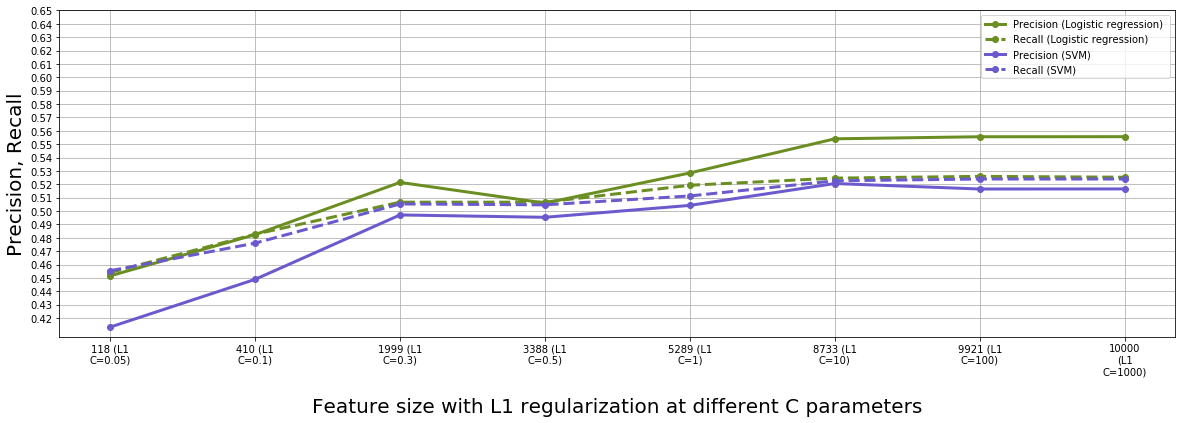

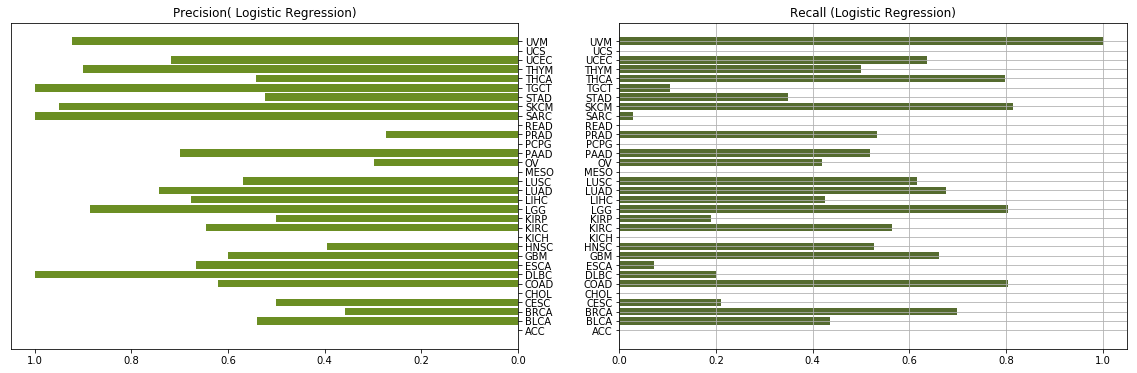

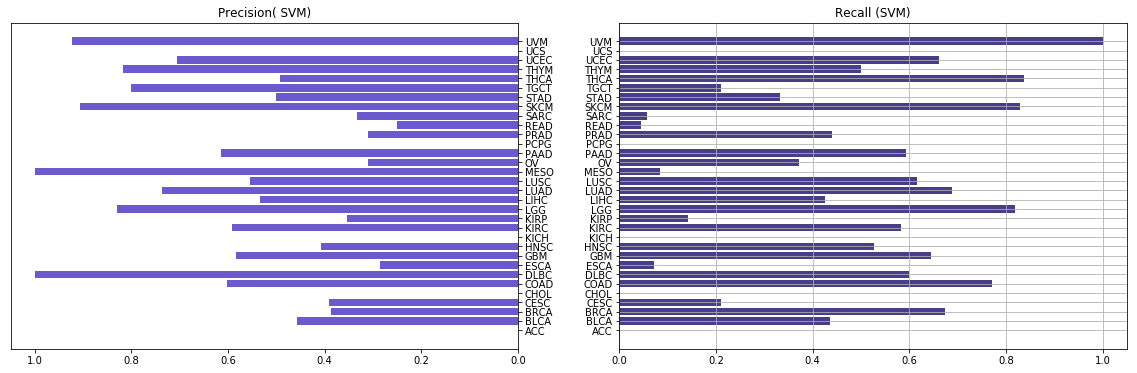

,actual,predicted,actual_name,predicted_name,error_rate,error_count
0,READ,COAD,Rectum_adenocarcinoma,Colon_adenocarcinoma,0.772727,17
1,PCPG,THCA,Pheochromocytoma_and_Paraganglioma,Thyroid_carcinoma,0.555556,15
2,MESO,BRCA,Mesothelioma,Breast_invasive_carcinoma,0.500000,6
3,ACC,BRCA,Adrenocortical_carcinoma,Breast_invasive_carcinoma,0.500000,7
4,KICH,BRCA,Kidney_Chromophobe,Breast_invasive_carcinoma,0.400000,4
5,KICH,PRAD,Kidney_Chromophobe,Prostate_adenocarcinoma,0.400000,4
6,UCS,OV,Uterine_Carcinosarcoma,Ovarian_serous_cystadenocarcinoma,0.333333,3
7,KIRP,BRCA,Kidney_renal_papillary_cell_carcinoma,Breast_invasive_carcinoma,0.333333,14
8,OV,BRCA,Ovarian_serous_cystadenocarcinoma,Breast_invasive_carcinoma,0.322581,20
9,TGCT,THCA,Testicular_Germ_Cell_Tumors,Thyroid_carcinoma,0.315789,6


In [15]:
runClassifier('best_fit_10000', logit_c_param=.15, svm_c_param=.01)

training data: (6004, 15000)
dev data     : (1502, 15000)
test data    : (2502, 15000)

Best precision 14672 (L1 C=100)
  precision: 0.6054
  recall:    0.5619

Best recall 11091 (L1 C=10)
  precision: 0.5852
  recall:    0.5626


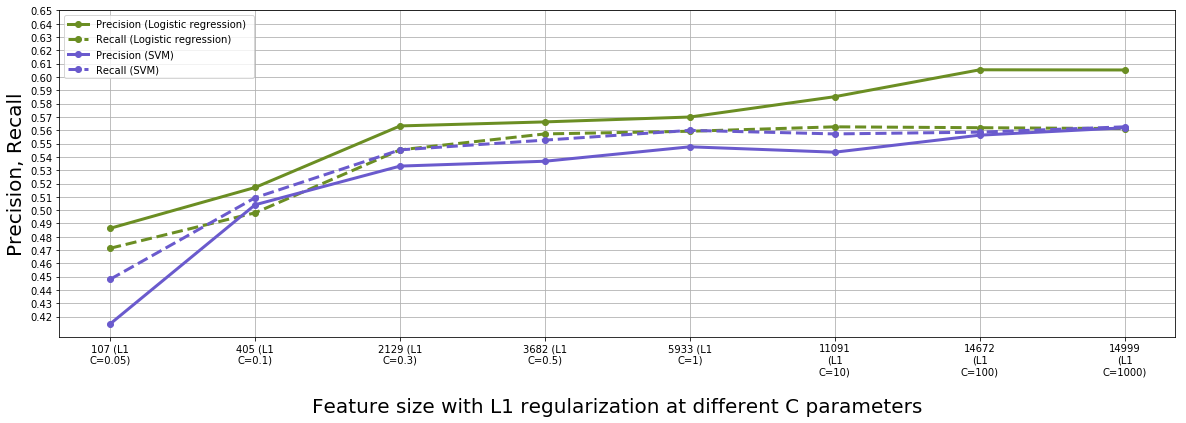

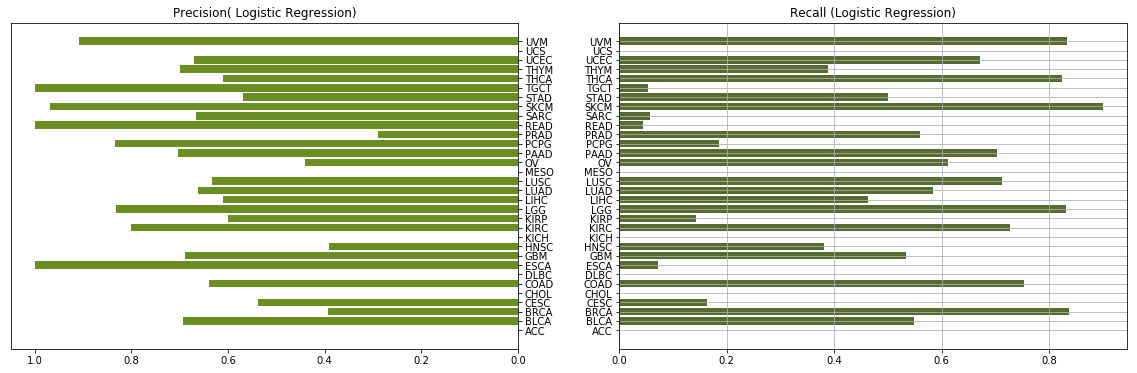

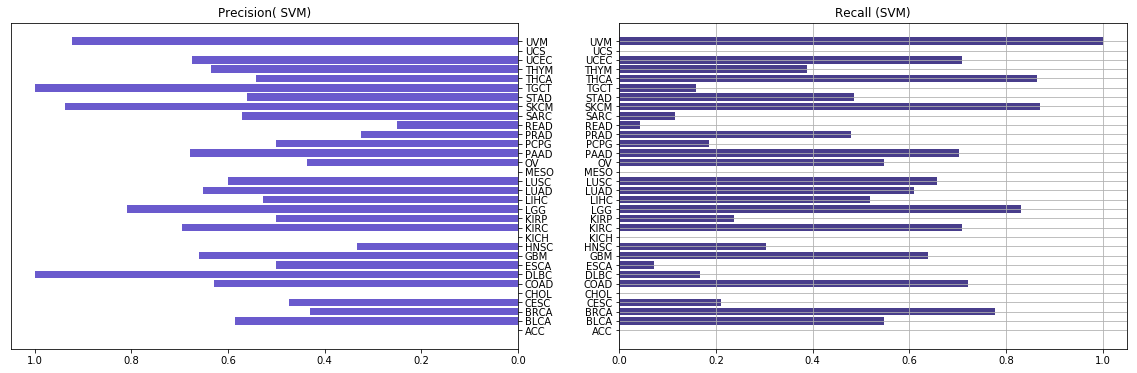

,actual,predicted,actual_name,predicted_name,error_rate,error_count
0,READ,COAD,Rectum_adenocarcinoma,Colon_adenocarcinoma,0.652174,15
1,UCS,BRCA,Uterine_Carcinosarcoma,Breast_invasive_carcinoma,0.555556,5
2,MESO,PRAD,Mesothelioma,Prostate_adenocarcinoma,0.500000,6
3,THYM,PRAD,Thymoma,Prostate_adenocarcinoma,0.444444,8
4,KICH,BRCA,Kidney_Chromophobe,Breast_invasive_carcinoma,0.400000,4
5,KICH,PRAD,Kidney_Chromophobe,Prostate_adenocarcinoma,0.400000,4
6,CESC,BRCA,Cervical_squamous_cell_carcinoma_and_endocervi...,Breast_invasive_carcinoma,0.372093,16
7,PCPG,PRAD,Pheochromocytoma_and_Paraganglioma,Prostate_adenocarcinoma,0.370370,10
8,TGCT,PRAD,Testicular_Germ_Cell_Tumors,Prostate_adenocarcinoma,0.368421,7
9,ACC,PRAD,Adrenocortical_carcinoma,Prostate_adenocarcinoma,0.357143,5


In [29]:
runClassifier('best_fit_15000', logit_c_param=.1, svm_c_param=.01)

training data: (6004, 15000)
dev data     : (1502, 15000)
test data    : (2502, 15000)

Best precision 14672 (L1 C=100)
  precision: 0.6047
  recall:    0.5646

Best recall 14672 (L1 C=100)
  precision: 0.6047
  recall:    0.5646


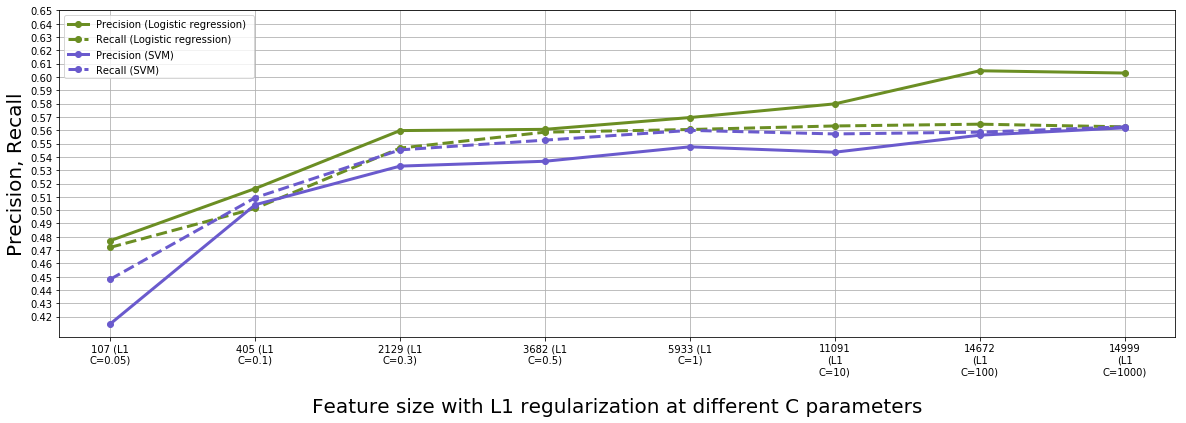

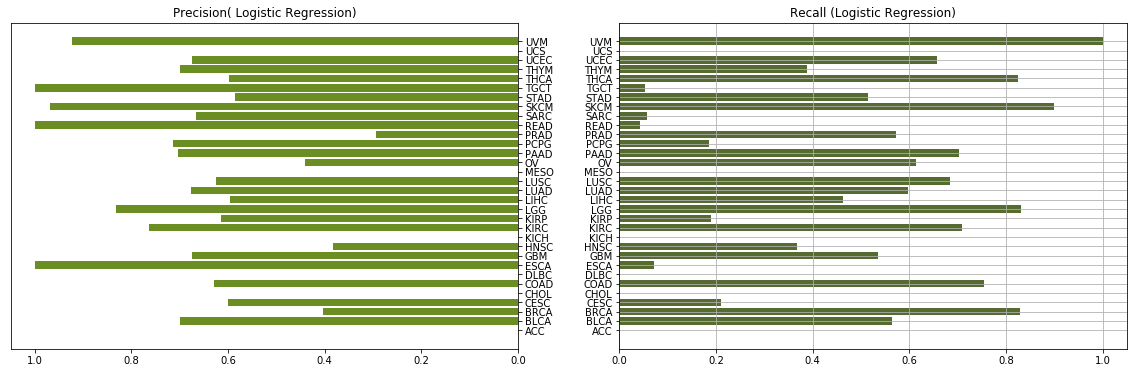

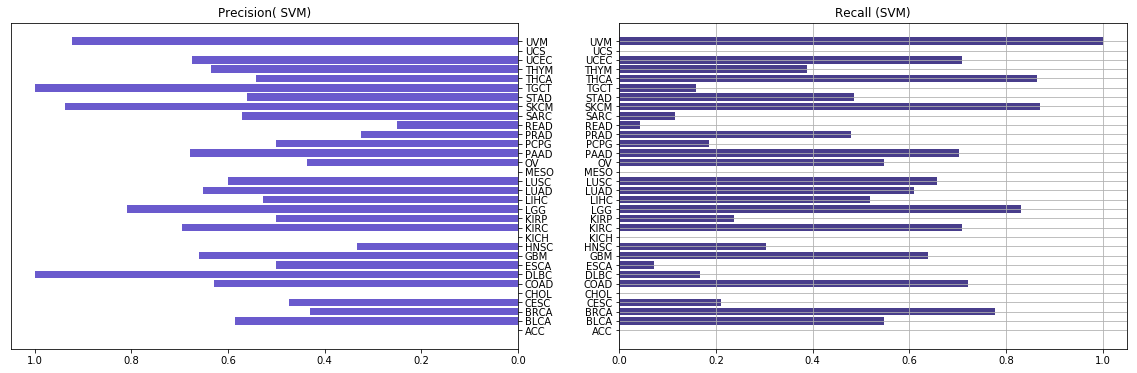

,actual,predicted,actual_name,predicted_name,error_rate,error_count
0,READ,COAD,Rectum_adenocarcinoma,Colon_adenocarcinoma,0.695652,16
1,UCS,BRCA,Uterine_Carcinosarcoma,Breast_invasive_carcinoma,0.555556,5
2,MESO,PRAD,Mesothelioma,Prostate_adenocarcinoma,0.500000,6
3,KICH,PRAD,Kidney_Chromophobe,Prostate_adenocarcinoma,0.500000,5
4,THYM,PRAD,Thymoma,Prostate_adenocarcinoma,0.444444,8
5,ACC,PRAD,Adrenocortical_carcinoma,Prostate_adenocarcinoma,0.428571,6
6,PCPG,PRAD,Pheochromocytoma_and_Paraganglioma,Prostate_adenocarcinoma,0.370370,10
7,TGCT,PRAD,Testicular_Germ_Cell_Tumors,Prostate_adenocarcinoma,0.368421,7
8,TGCT,THCA,Testicular_Germ_Cell_Tumors,Thyroid_carcinoma,0.368421,7
9,CESC,BRCA,Cervical_squamous_cell_carcinoma_and_endocervi...,Breast_invasive_carcinoma,0.348837,15


In [30]:
runClassifier('best_fit_15000', logit_c_param=.12, svm_c_param=.01)

training data: (6004, 15000)
dev data     : (1502, 15000)
test data    : (2502, 15000)

Best precision 14672 (L1 C=100)
  precision: 0.601
  recall:    0.5632

Best recall 11091 (L1 C=10)
  precision: 0.5764
  recall:    0.5632


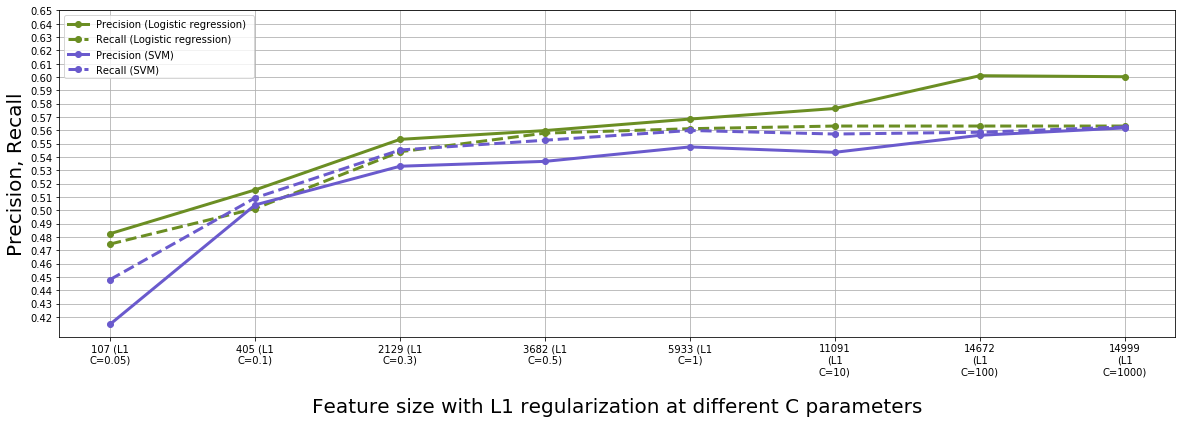

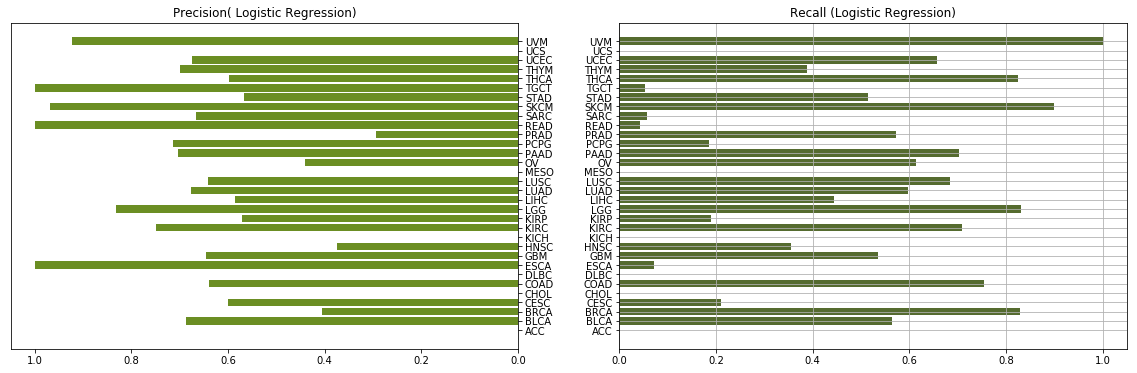

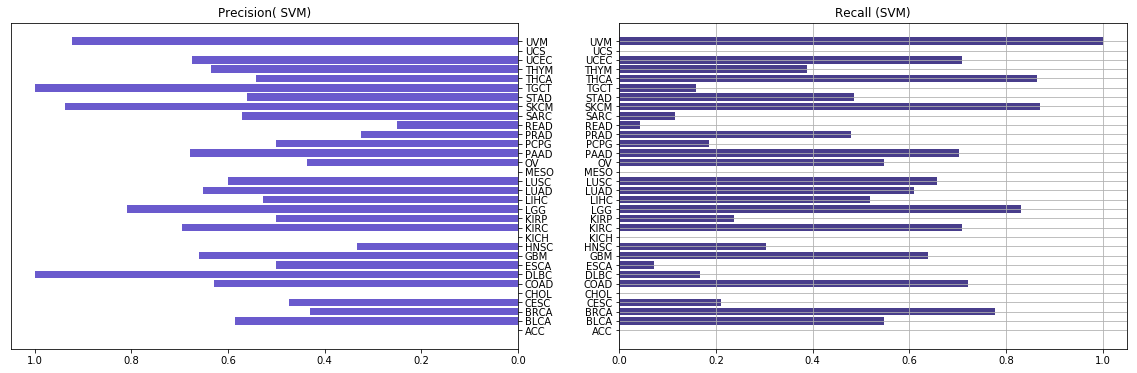

,actual,predicted,actual_name,predicted_name,error_rate,error_count
0,READ,COAD,Rectum_adenocarcinoma,Colon_adenocarcinoma,0.652174,15
1,UCS,BRCA,Uterine_Carcinosarcoma,Breast_invasive_carcinoma,0.555556,5
2,KICH,PRAD,Kidney_Chromophobe,Prostate_adenocarcinoma,0.500000,5
3,MESO,PRAD,Mesothelioma,Prostate_adenocarcinoma,0.500000,6
4,THYM,PRAD,Thymoma,Prostate_adenocarcinoma,0.444444,8
5,ACC,PRAD,Adrenocortical_carcinoma,Prostate_adenocarcinoma,0.428571,6
6,PCPG,PRAD,Pheochromocytoma_and_Paraganglioma,Prostate_adenocarcinoma,0.370370,10
7,TGCT,PRAD,Testicular_Germ_Cell_Tumors,Prostate_adenocarcinoma,0.368421,7
8,TGCT,THCA,Testicular_Germ_Cell_Tumors,Thyroid_carcinoma,0.368421,7
9,CESC,BRCA,Cervical_squamous_cell_carcinoma_and_endocervi...,Breast_invasive_carcinoma,0.348837,15


In [31]:
runClassifier('best_fit_15000', logit_c_param=.13, svm_c_param=.01)

training data: (6004, 15000)
dev data     : (1502, 15000)
test data    : (2502, 15000)

Best precision 14672 (L1 C=100)
  precision: 0.6054
  recall:    0.5619

Best recall 11091 (L1 C=10)
  precision: 0.5852
  recall:    0.5626


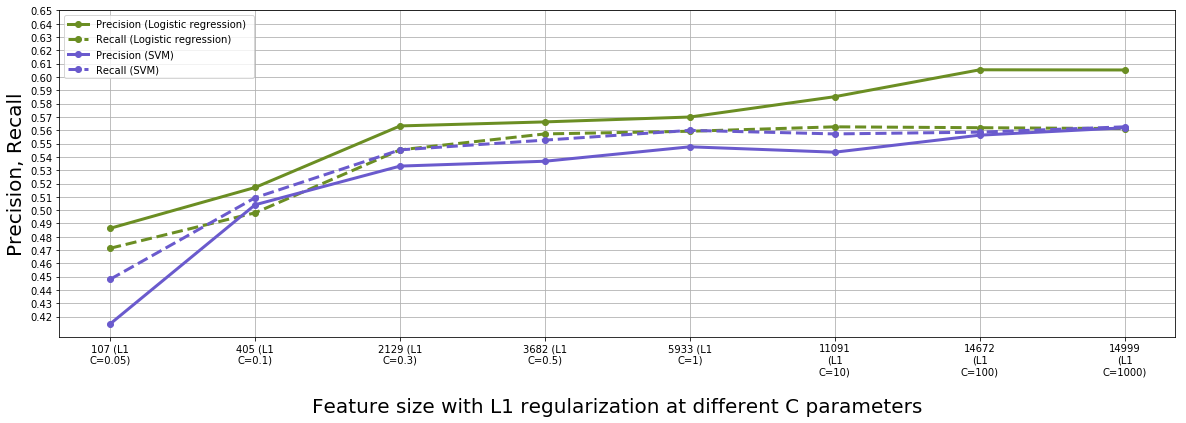

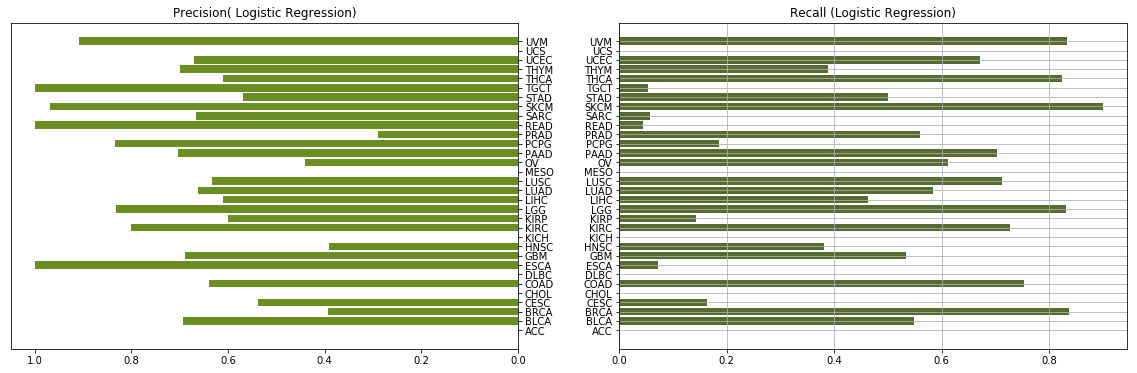

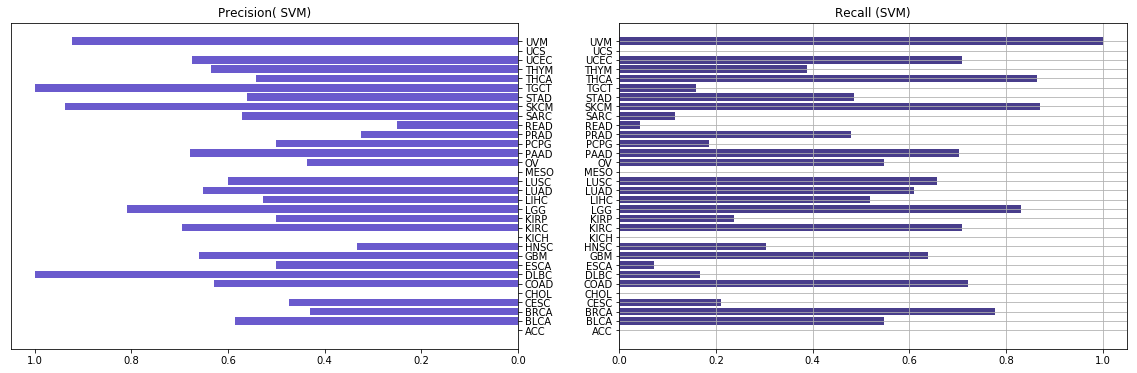

,actual,predicted,actual_name,predicted_name,error_rate,error_count
0,READ,COAD,Rectum_adenocarcinoma,Colon_adenocarcinoma,0.652174,15
1,UCS,BRCA,Uterine_Carcinosarcoma,Breast_invasive_carcinoma,0.555556,5
2,MESO,PRAD,Mesothelioma,Prostate_adenocarcinoma,0.500000,6
3,THYM,PRAD,Thymoma,Prostate_adenocarcinoma,0.444444,8
4,KICH,BRCA,Kidney_Chromophobe,Breast_invasive_carcinoma,0.400000,4
5,KICH,PRAD,Kidney_Chromophobe,Prostate_adenocarcinoma,0.400000,4
6,CESC,BRCA,Cervical_squamous_cell_carcinoma_and_endocervi...,Breast_invasive_carcinoma,0.372093,16
7,PCPG,PRAD,Pheochromocytoma_and_Paraganglioma,Prostate_adenocarcinoma,0.370370,10
8,TGCT,PRAD,Testicular_Germ_Cell_Tumors,Prostate_adenocarcinoma,0.368421,7
9,ACC,PRAD,Adrenocortical_carcinoma,Prostate_adenocarcinoma,0.357143,5


In [32]:
runClassifier('best_fit_15000_allgenes', logit_c_param=.1, svm_c_param=.01)

training data: (6004, 15000)
dev data     : (1502, 15000)
test data    : (2502, 15000)

Best precision 14672 (L1 C=100)
  precision: 0.6049
  recall:    0.5626

Best recall 11091 (L1 C=10)
  precision: 0.5838
  recall:    0.5632


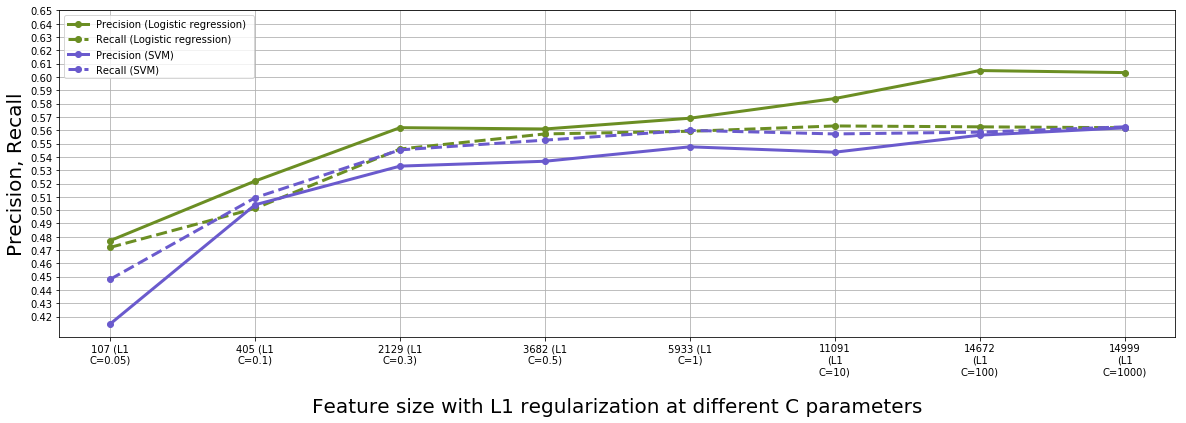

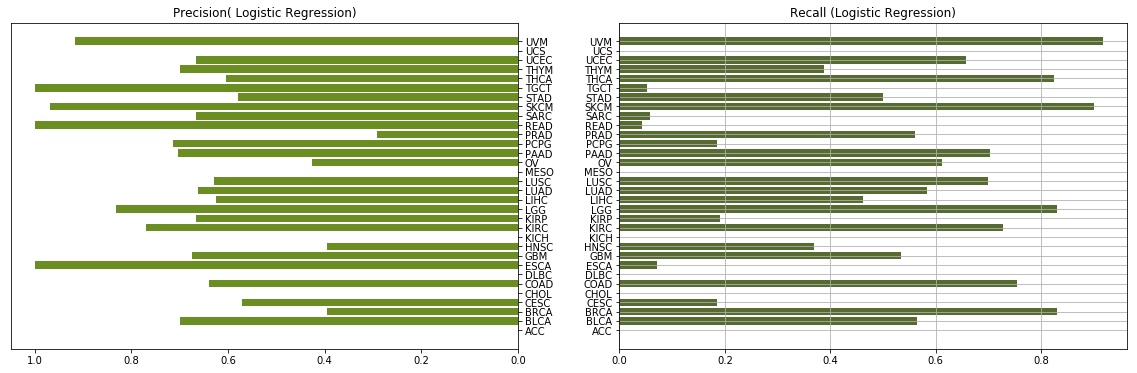

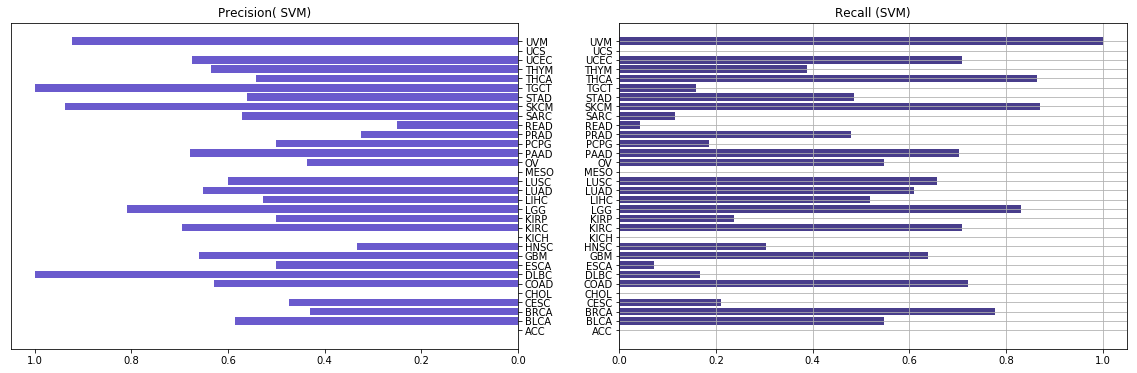

,actual,predicted,actual_name,predicted_name,error_rate,error_count
0,READ,COAD,Rectum_adenocarcinoma,Colon_adenocarcinoma,0.652174,15
1,UCS,BRCA,Uterine_Carcinosarcoma,Breast_invasive_carcinoma,0.555556,5
2,MESO,PRAD,Mesothelioma,Prostate_adenocarcinoma,0.500000,6
3,THYM,PRAD,Thymoma,Prostate_adenocarcinoma,0.444444,8
4,ACC,PRAD,Adrenocortical_carcinoma,Prostate_adenocarcinoma,0.428571,6
5,KICH,PRAD,Kidney_Chromophobe,Prostate_adenocarcinoma,0.400000,4
6,KICH,BRCA,Kidney_Chromophobe,Breast_invasive_carcinoma,0.400000,4
7,CESC,BRCA,Cervical_squamous_cell_carcinoma_and_endocervi...,Breast_invasive_carcinoma,0.372093,16
8,PCPG,PRAD,Pheochromocytoma_and_Paraganglioma,Prostate_adenocarcinoma,0.370370,10
9,TGCT,PRAD,Testicular_Germ_Cell_Tumors,Prostate_adenocarcinoma,0.368421,7


In [33]:
runClassifier('best_fit_15000_allgenes', logit_c_param=.11, svm_c_param=.01)

training data: (6004, 15000)
dev data     : (1502, 15000)
test data    : (2502, 15000)

Best precision 14672 (L1 C=100)
  precision: 0.6047
  recall:    0.5646

Best recall 14672 (L1 C=100)
  precision: 0.6047
  recall:    0.5646


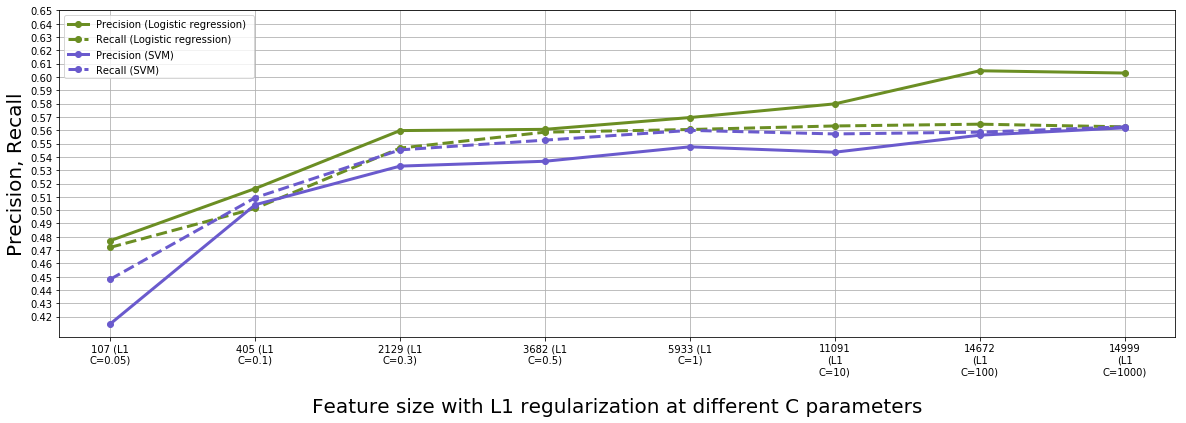

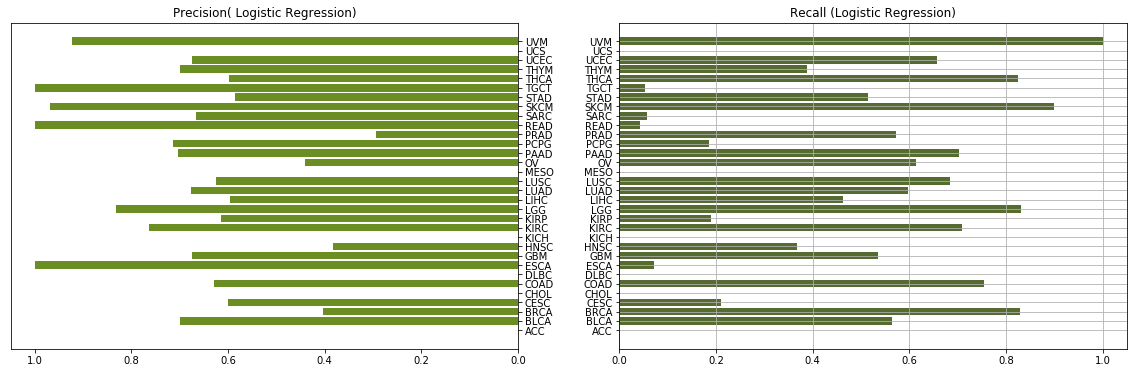

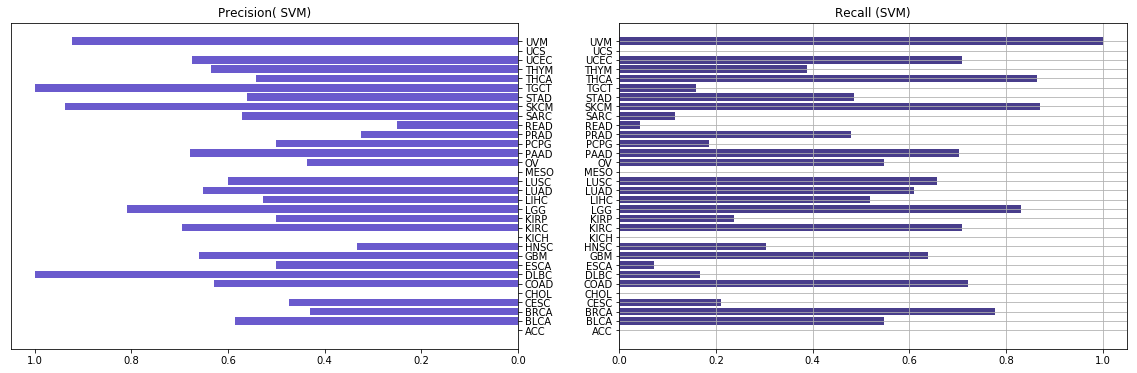

,actual,predicted,actual_name,predicted_name,error_rate,error_count
0,READ,COAD,Rectum_adenocarcinoma,Colon_adenocarcinoma,0.695652,16
1,UCS,BRCA,Uterine_Carcinosarcoma,Breast_invasive_carcinoma,0.555556,5
2,MESO,PRAD,Mesothelioma,Prostate_adenocarcinoma,0.500000,6
3,KICH,PRAD,Kidney_Chromophobe,Prostate_adenocarcinoma,0.500000,5
4,THYM,PRAD,Thymoma,Prostate_adenocarcinoma,0.444444,8
5,ACC,PRAD,Adrenocortical_carcinoma,Prostate_adenocarcinoma,0.428571,6
6,PCPG,PRAD,Pheochromocytoma_and_Paraganglioma,Prostate_adenocarcinoma,0.370370,10
7,TGCT,PRAD,Testicular_Germ_Cell_Tumors,Prostate_adenocarcinoma,0.368421,7
8,TGCT,THCA,Testicular_Germ_Cell_Tumors,Thyroid_carcinoma,0.368421,7
9,CESC,BRCA,Cervical_squamous_cell_carcinoma_and_endocervi...,Breast_invasive_carcinoma,0.348837,15


In [34]:
runClassifier('best_fit_15000_allgenes', logit_c_param=.12, svm_c_param=.01)

training data: (6004, 19209)
dev data     : (1502, 19209)
test data    : (2502, 19209)

Best precision 17702 (L1 C=100)
  precision: 0.5949
  recall:    0.5613

Best recall 19142 (L1 C=1000)
  precision: 0.5933
  recall:    0.5619


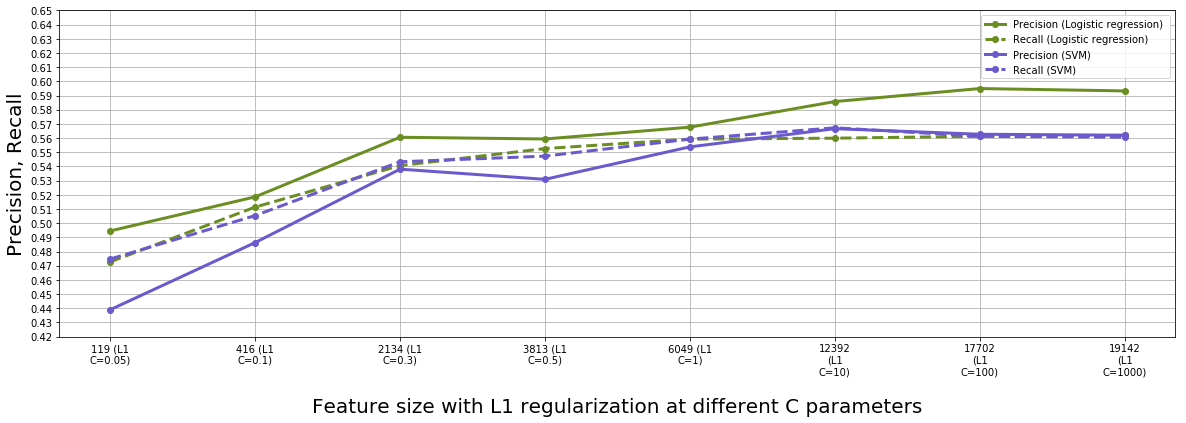

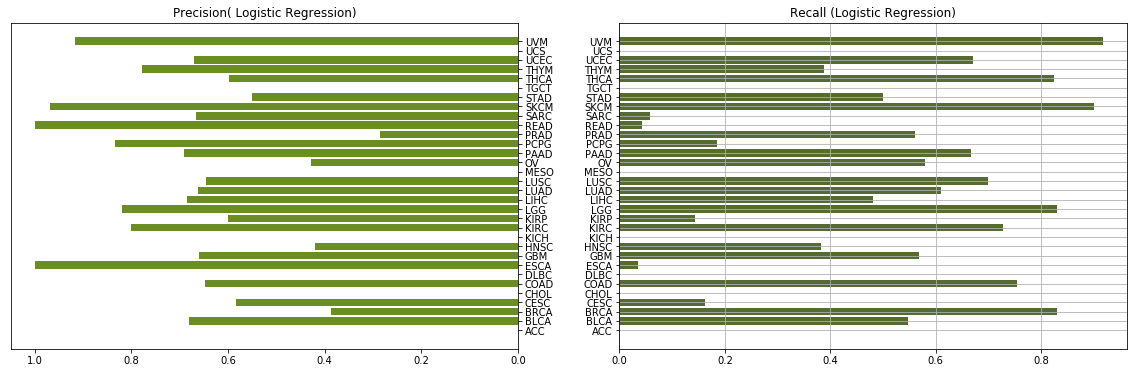

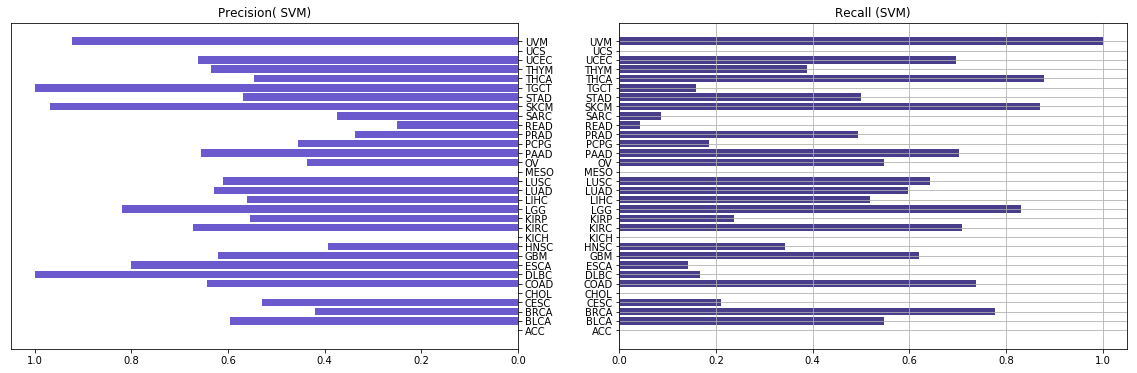

,actual,predicted,actual_name,predicted_name,error_rate,error_count
0,READ,COAD,Rectum_adenocarcinoma,Colon_adenocarcinoma,0.652174,15
1,UCS,BRCA,Uterine_Carcinosarcoma,Breast_invasive_carcinoma,0.555556,5
2,KICH,PRAD,Kidney_Chromophobe,Prostate_adenocarcinoma,0.500000,5
3,MESO,PRAD,Mesothelioma,Prostate_adenocarcinoma,0.500000,6
4,THYM,PRAD,Thymoma,Prostate_adenocarcinoma,0.444444,8
5,CESC,BRCA,Cervical_squamous_cell_carcinoma_and_endocervi...,Breast_invasive_carcinoma,0.372093,16
6,PCPG,PRAD,Pheochromocytoma_and_Paraganglioma,Prostate_adenocarcinoma,0.370370,10
7,TGCT,PRAD,Testicular_Germ_Cell_Tumors,Prostate_adenocarcinoma,0.368421,7
8,TGCT,THCA,Testicular_Germ_Cell_Tumors,Thyroid_carcinoma,0.368421,7
9,ACC,BRCA,Adrenocortical_carcinoma,Breast_invasive_carcinoma,0.357143,5


In [36]:
runClassifier('genes_all', logit_c_param=.1, svm_c_param=.01)

training data: (6004, 19209)
dev data     : (1502, 19209)
test data    : (2502, 19209)

Best precision 19142 (L1 C=1000)
  precision: 0.5991
  recall:    0.5646

Best recall 19142 (L1 C=1000)
  precision: 0.5991
  recall:    0.5646


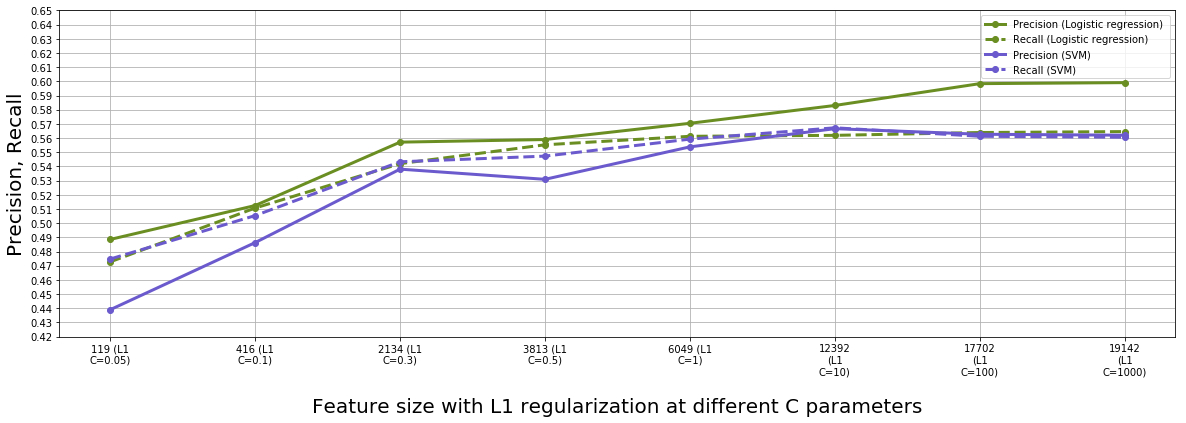

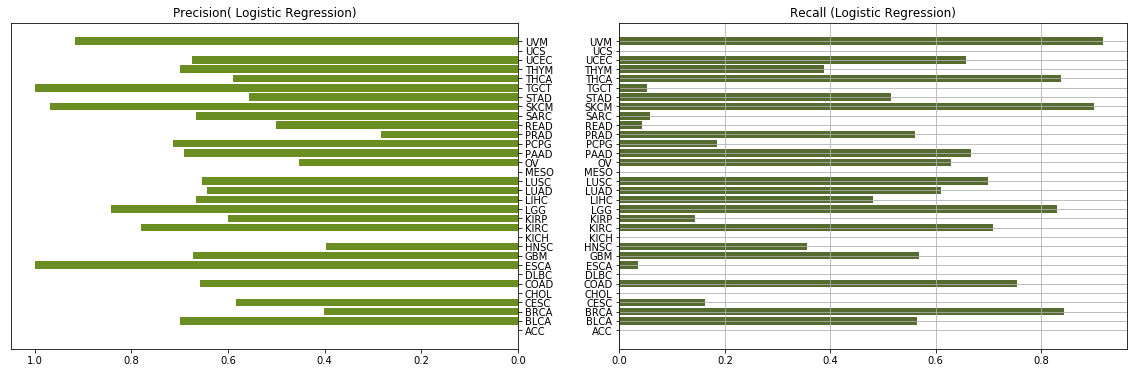

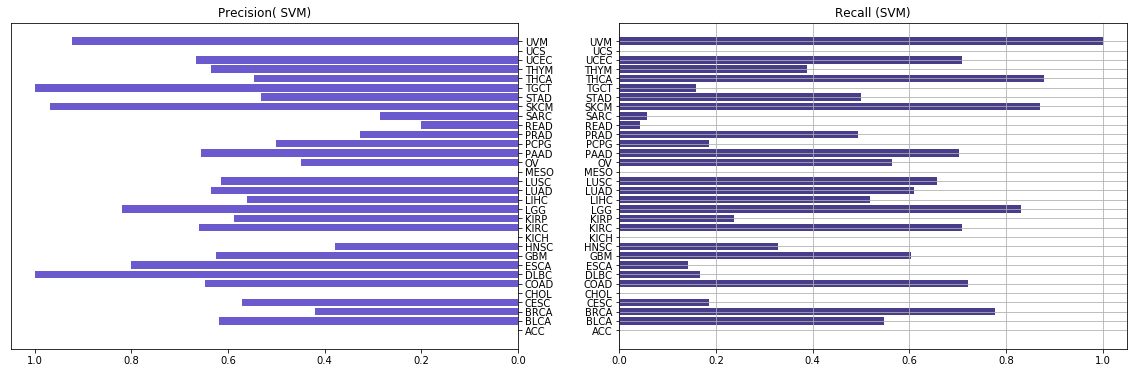

,actual,predicted,actual_name,predicted_name,error_rate,error_count
0,READ,COAD,Rectum_adenocarcinoma,Colon_adenocarcinoma,0.652174,15
1,UCS,BRCA,Uterine_Carcinosarcoma,Breast_invasive_carcinoma,0.555556,5
2,MESO,PRAD,Mesothelioma,Prostate_adenocarcinoma,0.500000,6
3,TGCT,PRAD,Testicular_Germ_Cell_Tumors,Prostate_adenocarcinoma,0.421053,8
4,KICH,PRAD,Kidney_Chromophobe,Prostate_adenocarcinoma,0.400000,4
5,THYM,PRAD,Thymoma,Prostate_adenocarcinoma,0.388889,7
6,CESC,BRCA,Cervical_squamous_cell_carcinoma_and_endocervi...,Breast_invasive_carcinoma,0.372093,16
7,PCPG,PRAD,Pheochromocytoma_and_Paraganglioma,Prostate_adenocarcinoma,0.370370,10
8,ACC,BRCA,Adrenocortical_carcinoma,Breast_invasive_carcinoma,0.357143,5
9,ACC,PRAD,Adrenocortical_carcinoma,Prostate_adenocarcinoma,0.357143,5


In [37]:
runClassifier('genes_all', logit_c_param=.12, svm_c_param=.01)